## Burgers equation with gradient corrections. 

The theory is in: https://arxiv.org/pdf/1908.01419

In [19]:
using Plots
using Revise
# include project utilities
includet("choques_utils.jl")
# complementary_utils.jl is included so its TVD routines are available if you want to call them.
includet("complementary_utils.jl")



### Log: 
(here we write the status of the code)




In [20]:
# Grid setup
function generate_grid(n::Int, L::Float64, x0::Float64)
    dx = L / (n-1)
    x_p = ((0:n-1) .* dx) .+ x0; # cell edges
    x_centers = ((0:n-2) .* dx) .+ dx/2 .+ x0; # cell centers
    x_centers_ext = vcat(-5dx/2,-3dx/2, -dx/2, x_centers, L+dx/2, L+3dx/2, L+5dx/2); # extended cell centers for BCs
    return dx, x_p, x_centers, x_centers_ext
end
n = 201
L = 1.0
x0 = 0.0
dx, x_p, x_centers, x_centers_ext = generate_grid(n, L, x0)


(0.005, 0.0:0.005:1.0, 0.0025:0.005:0.9975, [-0.0125, -0.0075, -0.0025, 0.0025, 0.0075, 0.0125, 0.0175, 0.0225, 0.0275, 0.0325  …  0.9675, 0.9725, 0.9775, 0.9825, 0.9875, 0.9925, 0.9975, 1.0025, 1.0075, 1.0125])

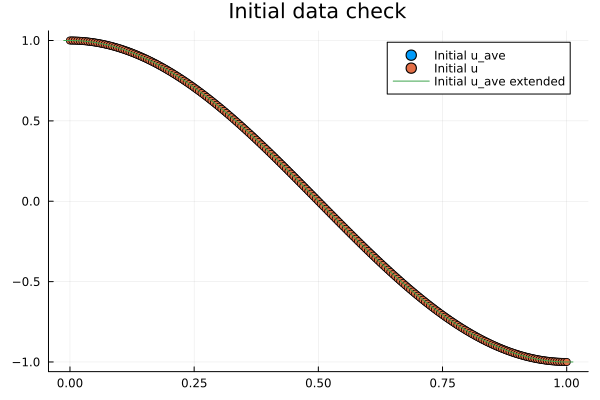

In [21]:
# Parameters for evolution
η = 0.005  # viscosity parameter
ζ = 1.0*dx^2  # gradient correction parameter
dt = 0.5*min(dx * dx / η, dx)  # CFL-based timestep
#dt = 0.5*dx
    
# Initial condition: smooth bump
#u0 = @. exp(-(x_centers - L/2)^2 * 4)
    

# As u we use cos(2π * x/2) as \bar(u) we get  2(sin(2π * (x+dx/2)/2) - sin(2π * (x-dx/2)/2)/dx

function generate_initial_data(x_centers, dx)
    #generate the points
    u_bar_int = 2/dx*(sin.(2π * x_centers/2) - sin.((2π * x_centers .-dx)/2))
    # extend to the larger grid with ghost cells
    u0 = vcat(u_bar_int[1],u_bar_int[1],u_bar_int[1], u_bar_int, u_bar_int[end],u_bar_int[end], u_bar_int[end]); # Ghost cells with constant values
    return u0
end

u0 = generate_initial_data(x_centers, dx)
scatter(x_centers, u0[4:end-3], label="Initial u_ave", title="Initial data check")
#scatter!(x_centers, cos.(2π* x_centers./2), label="Initial u") #This is correct
scatter!(x_p, cos.(2π* x_p./2), label="Initial u") #This is correct
plot!(x_centers_ext, u0, label="Initial u_ave extended") # This is correct, but the centers at the boundaries are a bit off. 
#u = copy(u0)

 

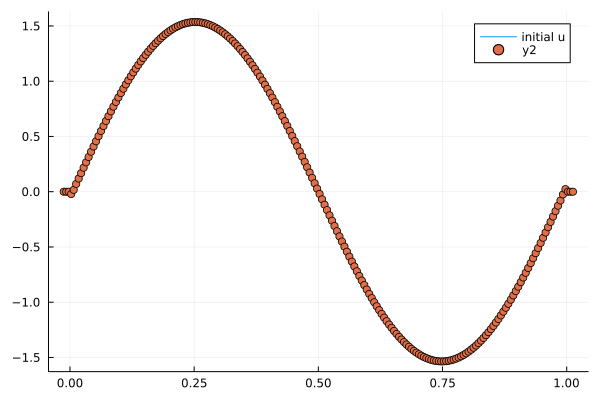

In [22]:
t = 0
du = zeros(length(u0));
plot(x_centers_ext, burgers_rhs_wgrad(u0, t, (dx, η, ζ, du)), label="initial u")
scatter!((x_centers_ext, burgers_rhs(u0, t, (dx, η, du))))

In [23]:


function evolve(t_interval, u0, params)
    du = zeros(length(u0))
    u = copy(u0)
    # Time evolution with TVD3
    t = t_interval[1]
    #params = (dx, η, ζ, du)
    nsteps = round(Int, t_interval[2]/dt)
    
    
    
    # Basic tests before evolution
    @show length(u) == n + 5 # Correct size with ghost cells
    @show maximum(abs.(u .- u0)) < 1e-14
    
    # Evolve (f,y0,t0,h,pf)
    max_u = zeros(nsteps)
    int_u = zeros(nsteps)
    #t_int = zeros(nsteps)
    max_u[1] = maximum(u[4:n+2])
    int_u[1] = sum(u[4:n+2])*dx
    t_int[1] = t
    
    for i in 2:nsteps
        TVD3_Step!(burgers_rhs_wgrad, u, t, dt, params)
        println("t = $t, max_u = $(maximum(u[4:n+2])), int_u = $(sum(u[4:n+2])*dx)")
        max_u[i] = maximum(u[4:n+2])
        int_u[i] = sum(u[4:n+2])*dx
        t += dt
        t_int[i] = t
    end
    
    # Basic sanity checks after evolution
    @show !any(isnan.(u[4:n+2]))  # No NaNs
    @show maximum(abs.(u[4:n+2])) ≤ maximum(abs.(u0[4:n+2])) * 1.1  # Max principle approximately
    @show isapprox(sum(u[4:n+2]) * dx, sum(u0[4:n+2]) * dx,  rtol=1e-3)  # Mass conservation
return t, max_u, int_u, t_int, u
end


evolve (generic function with 1 method)

In [40]:
t_final = 40.0
t_interval = (0.0, t_final)
nsteps = round(Int, t_final/dt)
t_int = zeros(nsteps)
max_u = zeros(nsteps,length(ζs))
int_u = zeros(nsteps,length(ζs))
η = 0.005 
ζs = [0.0, 0.1*dx^2, 0.5*dx^2, 1.0*dx^2, 5.0*dx^2]
error_max = zeros(length(ζs))
error_L2 = zeros(length(ζs))
uL_s = zeros(n, length(ζs))

for ζ ∈ ζs
    println("Evolving with ζ = $ζ")
    params = (dx, η, ζ, du)
    i = findfirst(==(ζ), ζs)
    t, max_u[:,i], int_u[:,i], t_int, u_final = evolve(t_interval, u0, params)
    uL_s[:,i], uR, _, _ = WENOZ_FV_reconstruct_from_averages(u_final, dx)
    error_max[i] = maximum(abs.(uL_s[:,i] .- -tanh.((x_p .-L/2)/2/η)))
    error_L2[i] = sqrt(sum(uL_s[:,i] .- -tanh.((x_p .-L/2)/2/η)).^2)*dx
end

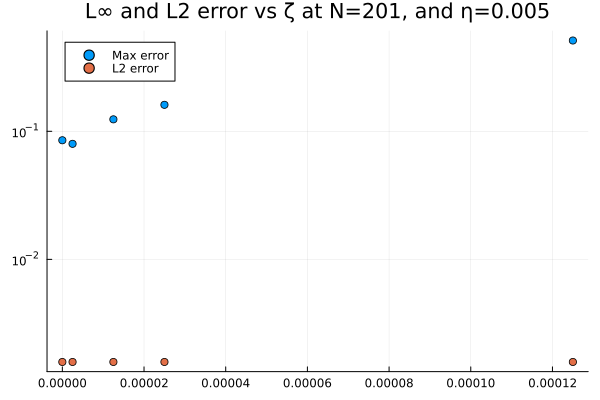

In [41]:
scatter(ζs, error_max, yscale=:log10, label="Max error", title="L∞ and L2 error vs ζ at N=$n, and η=$η")
scatter!(ζs, error_L2, yscale=:log10, label="L2 error")

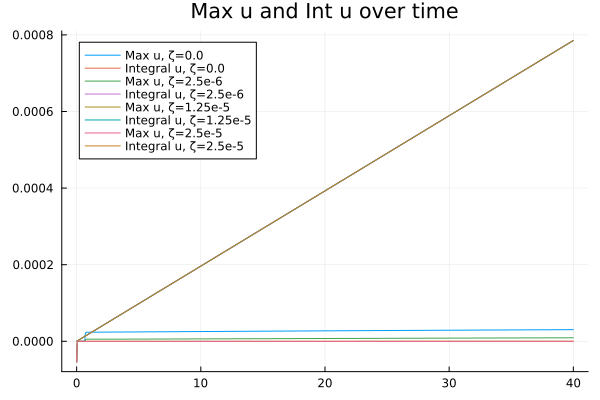

In [44]:
plt = plot(title="Max u and Int u over time")
for i in 1:length(ζs)-1
    plot!(plt, t_int[2:end], max_u[2:end,i] .- max_u[1,i], label="Max u, ζ=$(ζs[i])")
    plot!(plt, t_int[2:end], int_u[2:end,i] .- int_u[1,i], label="Integral u, ζ=$(ζs[i])")
end
display(plt)

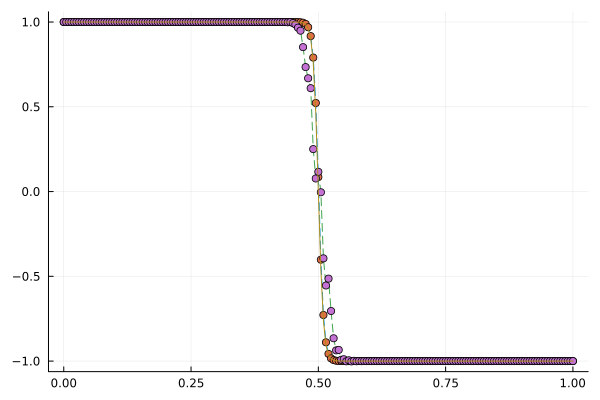

In [48]:
#plot(x_centers,u[4:end-3], label="u at t = $t_final")
#uL, uR, _, _ = WENOZ_FV_reconstruct_from_averages(u_final, dx)
i = 5
plot(x_p,uL_s[:,1], label="Reconstructed uL at t = $t_interval[2], ζ=$(ζs[1])", linestyle=:dash)
scatter!(x_p,uL_s[:,1], label="Reconstructed uL at t = $t_interval[2], ζ=$(ζs[1])")
plot!(x_p,uL_s[:,i], label="Reconstructed uL at t = $t_interval[2], ζ=$(ζs[i])", linestyle=:dash)
scatter!(x_p,uL_s[:,i], label="Reconstructed uL at t = $t_interval[2], ζ=$(ζs[i])")
plot!(x_p, -tanh.((x_p .-L/2)/2/η), label="limiting solution")
plot!(legend=:false)


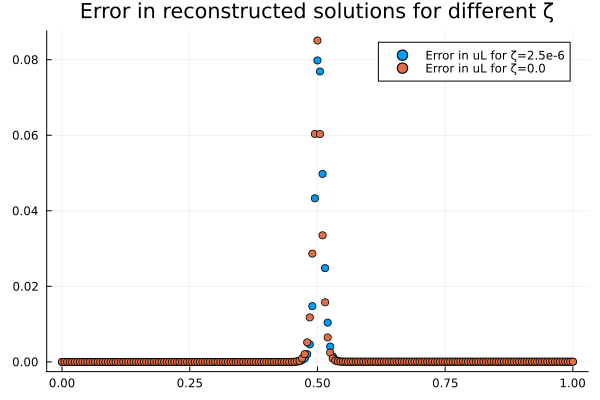

In [53]:
s = 2
scatter(x_p,uL_s[:,s] - -tanh.((x_p .-L/2)/2/η), label="Error in uL for ζ=$(ζs[s])", title="Error in reconstructed solutions for different ζ")
scatter!(x_p,uL_s[:,1] - -tanh.((x_p .-L/2)/2/η), label="Error in uL for ζ=$(ζs[1])")
#scatter!(x_p,uR - -tanh.((x_p .-L/2)/2/η), label="Error in uR")
#scatter!(x_p, (uL_s + uR_s)/2 - -tanh.((x_p .-L/2)/2/η), label="Error in average")